# Figures 

## ECCO

In [2]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [3]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
omega_total = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/omega_total_newbins.zarr'))
R1 = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/R1_newbins.zarr'))

In [5]:
wmt_budget_terms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms_newbins.zarr'))
wmt_budget_terms.load()

<xarray.Dataset>
Dimensions:               (time: 286, sigma2_bin: 99)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-02-13 ... 2015-11-14
    time_snp              (time) datetime64[ns] 1992-03-01 ... 2015-12-01
Data variables: (12/18)
    R1                    (time, sigma2_bin) float64 1.64e+06 ... -5.713e+04
    R2                    (time, sigma2_bin) float64 -2.276e+06 ... -8.799e+04
    R3                    (time, sigma2_bin) float64 -9.906e+03 ... -1.468e+03
    dVdt                  (time, sigma2_bin) float32 -1.173e+07 ... -9.151e+04
    omega_mix             (time, sigma2_bin) float64 -9.24e+06 ... -2.976e+03
    omega_mix_slt         (time, sigma2_bin) float64 -3.099e+06 ... -8.984e+03
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.363e+06 ... 1.814e+04
    omega_trans_rate      (time, sigma2_bin) float64 -1.052e+07 ... 5.508e+04
    omega_trans_rate_slt  (time, sigma2_bin) float64 -2.639e+06 ... 4.907e+04
    omega_trans_rate_th   (time, sigma2_bin) float64 -7.883e+06 ... 6.008e+03
    psi_adv               (time, sigma2_bin) float64 -2.833e+06 ... -8.799e+04
    psi_vel               (time, sigma2_bin) float32 -5.575e+05 ... -0.0

In [6]:
wmt_budget_terms.coords

Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    time_snp    (time) datetime64[ns] 1992-03-01 1992-04-01 ... 2015-12-01

In [7]:
omega_total.omega_total[:-1]

<xarray.DataArray 'omega_total' (time: 286, sigma2_bin: 99)>
dask.array<getitem, shape=(286, 99), dtype=float64, chunksize=(286, 99), chunktype=numpy.ndarray>
Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [8]:
R1.coords

Coordinates:
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03
  * time        (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
    time_snp    (time) datetime64[ns] dask.array<chunksize=(286,), meta=np.ndarray>

In [9]:
wmt_budget_terms['omega_total'] = omega_total.omega_total[:-1]
wmt_budget_terms['R1'] = R1.R1

In [10]:
wmt_budget_terms

<xarray.Dataset>
Dimensions:               (sigma2_bin: 99, time: 286)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 1992-02-13 ... 2015-11-14
    time_snp              (time) datetime64[ns] 1992-03-01 ... 2015-12-01
Data variables: (12/18)
    R1                    (time, sigma2_bin) float64 dask.array<chunksize=(286, 99), meta=np.ndarray>
    R2                    (time, sigma2_bin) float64 -2.276e+06 ... -8.799e+04
    R3                    (time, sigma2_bin) float64 -9.906e+03 ... -1.468e+03
    dVdt                  (time, sigma2_bin) float32 -1.173e+07 ... -9.151e+04
    omega_mix             (time, sigma2_bin) float64 -9.24e+06 ... -2.976e+03
    omega_mix_slt         (time, sigma2_bin) float64 -3.099e+06 ... -8.984e+03
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 -8.363e+06 ... 1.814e+04
    omega_trans_rate      (time, sigma2_bin) float64 -1.052e+07 ... 5.508e+04
    omega_trans_rate_slt  (time, sigma2_bin) float64 -2.639e+06 ... 4.907e+04
    omega_trans_rate_th   (time, sigma2_bin) float64 -7.883e+06 ... 6.008e+03
    psi_adv               (time, sigma2_bin) float64 -2.833e+06 ... -8.799e+04
    psi_vel               (time, sigma2_bin) float32 -5.575e+05 ... -0.0

In [68]:
#climatology ds
clim = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/clim_ds.zarr')).load()
#anomalous ds
anom = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/anom_ds.zarr')).load()

## Time mean budgets

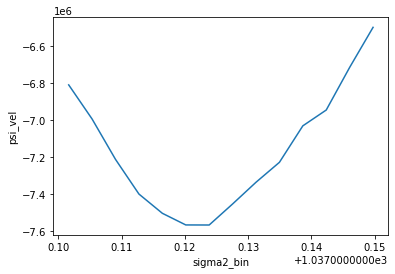

In [11]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.10, 1037.15)).plot()

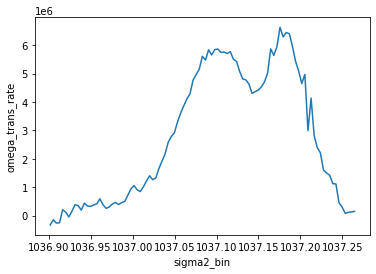

In [12]:
wmt_budget_terms.omega_trans_rate.mean('time').plot()

### $\frac{\partial V}{\partial t}$

In [13]:
#bottom
dVdt_bot = (wmt_budget_terms.dVdt.mean('time')[-1] - 
             wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
dVdt_bot.load()

<xarray.DataArray 'dVdt' ()>
array(1.28811375)

In [14]:
#deep
dVdt_deep = (wmt_budget_terms.dVdt.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.dVdt.mean('time')[0])/1e6
dVdt_deep.load()

<xarray.DataArray 'dVdt' ()>
array(-1.509369)

In [15]:
(wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6

3.104351291421289

In [16]:
dVdt_bot + dVdt_deep + (wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6

<xarray.DataArray 'dVdt' ()>
array(2.88309604)

### E-P-R

In [17]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

ds_ll = faces_dataset_to_latlon(ds)

ds_before_drop = ds_ll.roll(i=50, i_g=50)

ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

#WG boundaries (65˚W, 30˚E; 80˚S, 55˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745# 93 #-55.107994˚
j_g_lower = 31
j_g_upper = 81
i_g_right = 119
i_g_left = 24

#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat), j_g=slice(j_g_lower, j_g_upper))
lon_range = dict(i=slice(left_lon, right_lon), i_g=slice(i_g_left, i_g_right))

#set the boundaries
lat_range_noface = dict(j=slice(lower_lat, upper_lat))
lon_range_noface = dict(i=slice(left_lon, right_lon))

/tmp/ipykernel_723/2556715282.py:5: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  ds_before_drop = ds_ll.roll(i=50, i_g=50)


In [18]:
ds_wg = ds.isel(**lat_range, **lon_range)

In [19]:
ds_wg.oceFWflx

<xarray.DataArray 'oceFWflx' (time: 288, j: 50, i: 95)>
dask.array<getitem, shape=(288, 50, 95), dtype=float32, chunksize=(1, 50, 67), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    Depth    (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
Dimensions without coordinates: j, i
Attributes:
    long_name:      net surface Fresh-Water flux into the ocean (+=down), >0 ...
    standard_name:  oceFWflx
    units:          kg/m^2/s

In [20]:
ds_wg.rA

<xarray.DataArray 'rA' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 67), chunktype=numpy.ndarray>
Coordinates:
    Depth    (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    rA       (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
Dimensions without coordinates: j, i
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [21]:
mask = ds_wg.hFacC[0]>0

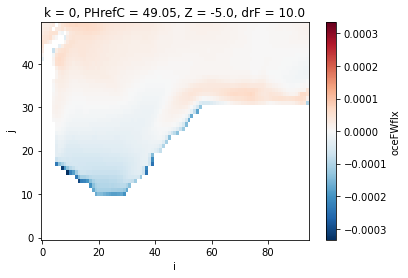

In [22]:
ds_wg.oceFWflx.mean(dim='time').where(mask).plot()

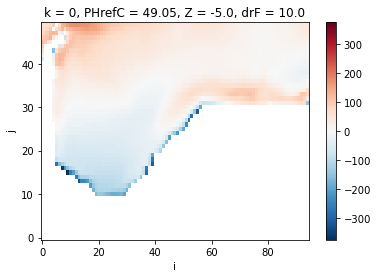

In [23]:
((ds_wg.oceFWflx*ds_wg.rA)/1035).mean('time').where(mask).plot()

In [24]:
e_minus_p = (ds_wg.oceFWflx * ds_wg.rA) / 1035 #m^3/s
e_minus_p.load()

<xarray.DataArray (time: 288, j: 50, i: 95)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ 86.99016   , 101.049     , 103.93102   , ...,   0.94915915,
           0.9775815 ,   1.2242587 ],
        [ 80.44932   ,  95.00412   ,  96.52832   , ...,   3.9090254 ,
           2.9930742 ,   3.0234442 ],
        [ 68.97897   ,  76.67485   ,  78.98671   , ...,   7.749116  ,
           6.74586   ,   5.9742537 ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [258.9434    , 289.2397    , 346.86627   , ..., 215.19272   ,
         223.83514   , 238.52647   ],
        [191.3968    , 252.30124   , 269.50195   , ..., 231.49101   ,
         246.5602    , 268.0985    ],
        [159.6993    , 172.75107   , 245.60216   , ..., 230.56105   ,
         247.29898   , 265.55716   ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ 40.627224  ,  50.929268  ,  77.06169   , ...,  47.285713  ,
          54.297752  ,  59.146935  ],
        [ 40.449493  ,  49.373077  ,  48.212868  , ...,  41.702724  ,
          41.63829   ,  31.432756  ],
        [ 34.475506  ,  38.87792   ,  44.579494  , ...,  39.75984   ,
          36.158787  ,  26.107569  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
    Depth    (j, i) float32 0.0 0.0 0.0 0.0 ... 5.184e+03 5.196e+03 5.197e+03
    XC       (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5
    YC       (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    iter     (time) int64 732 1428 2172 2892 ... 208164 208908 209628 210360
    rA       (j, i) float32 6.898e+08 6.944e+08 ... 2.635e+09 2.635e+09
Dimensions without coordinates: j, i

In [25]:
sigma2_vars = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/sigma2_vars.zarr'))
sigma2 = sigma2_vars.sigma2

delta_sigma = 3.7e-3
sigma_bins = np.arange(1036.9, 1037.27, delta_sigma)

/tmp/ipykernel_723/3729408013.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  sigma2_vars = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ECCO/datasets/wmt_budget_terms/sigma2_vars.zarr'))


In [26]:
fw = (- histogram(sigma2.isel(k=0).rename('sigma2'), bins=[sigma_bins],
                 weights=e_minus_p.fillna(0.),
                 dim=['i', 'j']) / (- delta_sigma)).load()
fw

<xarray.DataArray 'histogram_sigma2' (time: 288, sigma2_bin: 99)>
array([[      0.   ,       0.   ,       0.   , ...,       0.   ,
              0.   ,       0.   ],
       [      0.   ,       0.   ,       0.   , ...,       0.   ,
              0.   ,       0.   ],
       [-106035.16 ,       0.   , -255601.44 , ...,       0.   ,
              0.   ,       0.   ],
       ...,
       [  88071.19 ,  -22024.652,   26014.018, ...,       0.   ,
              0.   ,       0.   ],
       [ 549499.9  ,  974321.   ,  630340.2  , ...,       0.   ,
              0.   ,       0.   ],
       [ 203622.75 ,  173358.2  ,  327163.16 , ...,       0.   ,
              0.   ,       0.   ]], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * sigma2_bin  (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03 1.037e+03

### $\Psi$

In [27]:
psi_bot = (wmt_budget_terms.psi_vel.mean('time')[-1] - 
           wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
psi_bot.load()

<xarray.DataArray 'psi_vel' ()>
array(7.565823)

In [28]:
fw_bot = (fw.mean('time')[-1] - fw.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
fw_bot.load()

<xarray.DataArray 'histogram_sigma2' ()>
array(0.03239342)

In [29]:
psi_deep = (wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
            wmt_budget_terms.psi_vel.mean('time')[0])/1e6
psi_deep.load()

<xarray.DataArray 'psi_vel' ()>
array(-8.353571)

In [30]:
fw_deep = (fw.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
            fw.mean('time')[0])/1e6
fw_deep.load()

<xarray.DataArray 'histogram_sigma2' ()>
array(0.07955087)

In [31]:
(wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray 'R2' ()>
array(0.26585707)

In [32]:
#residual from transport in (deep wm) and out (bottom wm) after considering E-P-2 and R2 term
psi_bot + psi_deep + fw_bot + fw_deep + (wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray ()>
array(-0.40994665)

### $\Omega$

In [33]:
#bottom
omega_bot = (wmt_budget_terms.omega_trans_rate.mean('time')[-1] - 
             wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest'))/1e6
omega_bot.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(-5.34814462)

In [34]:
#deep
omega_deep = (wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.12, method='nearest') - 
              wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6
omega_deep.load()

<xarray.DataArray 'omega_trans_rate' ()>
array(5.82737966)

In [35]:
omega_bot + omega_deep

<xarray.DataArray 'omega_trans_rate' ()>
array(0.47923504)

In [36]:
(wmt_budget_terms.omega_trans_rate.mean('time')[-1] - wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(0.47923504)

### Budget

In [72]:
dVdt_bot

<xarray.DataArray 'dVdt' ()>
array(1.28811375)

In [76]:
psi_bot + omega_bot + fw_bot

<xarray.DataArray ()>
array(2.18528496)

(-8.0, 8.0)

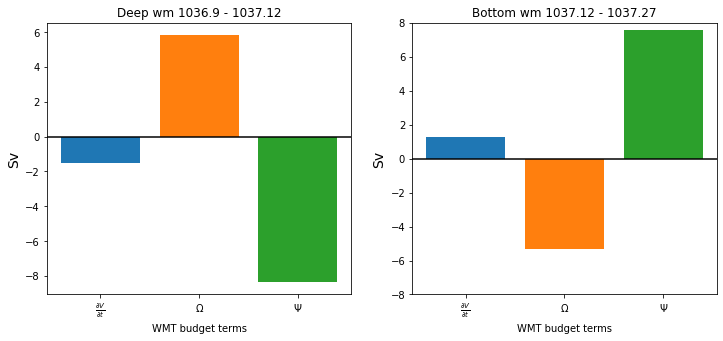

In [66]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_deep)
ax0.bar(x=r'$\Omega$', height = omega_deep)
ax0.bar(x=r'$\Psi$', height=psi_deep)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = dVdt_bot)
ax1.bar(x=r'$\Omega$', height = omega_bot)
ax1.bar(x=r'$\Psi$', height=psi_bot)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')

plt.ylim(-8,8);

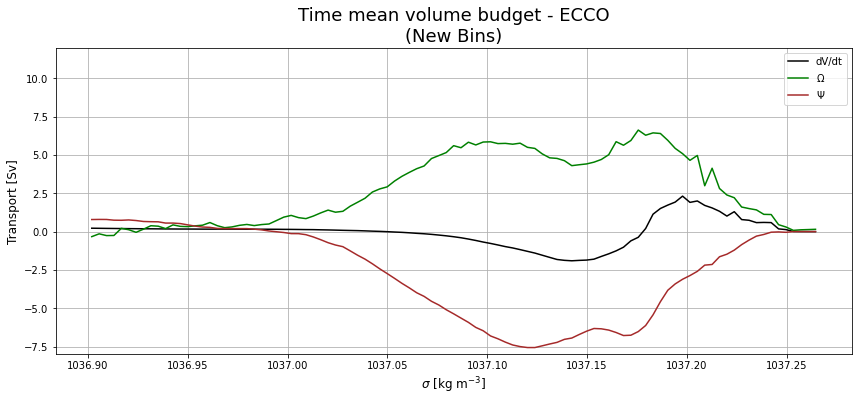

In [45]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
#(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title('Time mean volume budget - ECCO\n(New Bins)', fontsize=18);

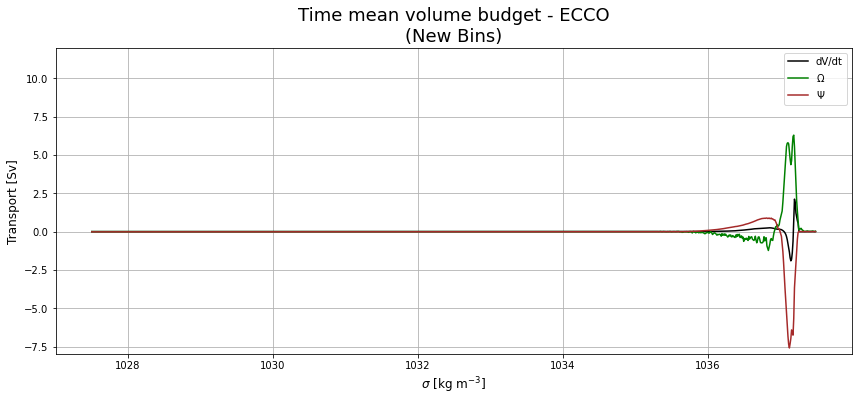

In [48]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
#(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title('Time mean volume budget - ECCO\n(New Bins)', fontsize=18);

In [21]:
def d_dsigma(da):
    """d/dsigma function to switch to formation view"""
    da = (da.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin')) / 1e6
    return da

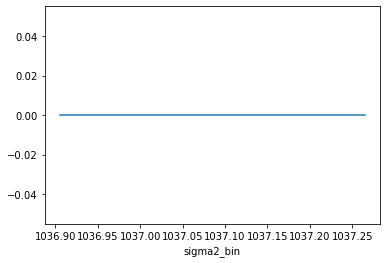

In [22]:
#check function works
(((wmt_budget_terms.omega_trans_rate.diff('sigma2_bin') / wmt_budget_terms.sigma2_bin.diff('sigma2_bin'))/1e6) - 
 d_dsigma(wmt_budget_terms.omega_trans_rate)).mean('time').plot();
#it works

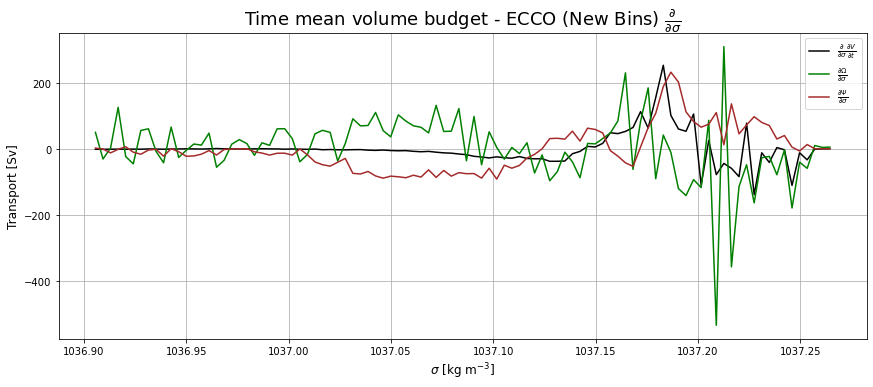

In [43]:
d_dsigma(wmt_budget_terms.dVdt).mean(dim='time').plot(label=r'$\frac{\partial}{\partial \sigma} \frac{\partial V}{\partial t}}$',
                                                      color='k', figsize=(12,5))
d_dsigma(wmt_budget_terms.omega_trans_rate).mean(dim='time').plot(label=r'$\frac{\partial \Omega}{\partial \sigma}$', color='green')
#d_dsigma(wmt_budget_terms.omega_trans_rate_th).mean(dim='time').plot(label=r'$\frac{\partial \Omega_{\theta}}{\partial \sigma}$', 
#                                                                     color='steelblue', linestyle='dashed')
#d_dsigma(wmt_budget_terms.omega_trans_rate_slt).mean(dim='time').plot(label=r'$\frac{\partial \Omega_S}{\partial \sigma}$', 
#                                                                      color='goldenrod', linestyle='dashed')
d_dsigma(wmt_budget_terms.psi_vel).mean(dim='time').plot(label=r'$\frac{\partial \Psi}{\partial \sigma}$', color='brown')
#d_dsigma(wmt_budget_terms.R2).mean(dim='time').plot(label=r'$\frac{\partial R2}{\partial \sigma}$', color='salmon')
#d_dsigma(wmt_budget_terms.R1).mean(dim='time').plot(label=r'$\frac{\partial R1}{\partial \sigma}$', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-8, 12)
#plt.xlim(1037.0, 1037.2)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - ECCO (New Bins) $\frac{\partial}{\partial \sigma}$', fontsize=18);

## Monthly Climatology

In [69]:
clim

<xarray.Dataset>
Dimensions:           (month: 12, sigma2_bin: 99)
Coordinates:
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * sigma2_bin        (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
Data variables:
    R1                (month, sigma2_bin) float64 -2.004 -2.348 ... 0.08886
    R2                (month, sigma2_bin) float64 -0.3877 -0.1803 ... -0.06612
    dVdt              (month, sigma2_bin) float32 -14.17 -13.89 ... -0.0124
    omega_mix         (month, sigma2_bin) float64 -9.124 -8.892 ... -0.08566
    omega_surf_slt    (month, sigma2_bin) float64 -0.9361 -0.6726 ... 0.02294
    omega_surf_th     (month, sigma2_bin) float64 -3.124 -3.11 ... -3.583e-07
    omega_trans_rate  (month, sigma2_bin) float64 -13.18 -12.67 ... -0.06271
    psi_vel           (month, sigma2_bin) float32 -0.1963 -0.2027 ... 0.0 0.0

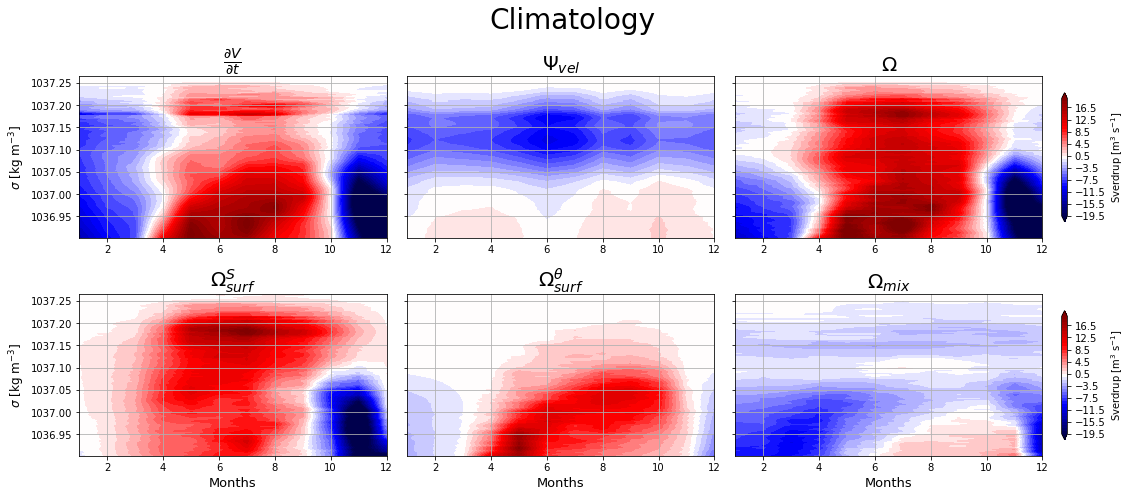

In [73]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim.dVdt 
c = ax[0,0].contourf(clim.month, 
                   clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].grid()

psi_vel_clim = clim.psi_vel 
c_psi = ax[0,1].contourf(clim.month, clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
ax[0,1].grid()

omega_clim = clim.omega_trans_rate 
c_omega = ax[0,2].contourf(clim.month, clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20)
ax[0,2].grid()

omega_surf_slt_clim = clim.omega_surf_slt
c_surf_slt = ax[1,0].contourf(clim.month, 
                                clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Months', fontsize=13)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
ax[1,0].grid()

omega_surf_th_clim = clim.omega_surf_th 
c_surf_th = ax[1,1].contourf(clim.month, clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
ax[1,1].grid()

omega_mix__clim = clim.omega_mix
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
ax[1,2].grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [77]:
dVdt_clim_deep = clim.dVdt.sel(sigma2_bin=1037.12, method='nearest') - clim.dVdt.isel(sigma2_bin=0)
dVdt_clim_deep.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([  6.2771206,   3.6908727,   1.826251 , -12.363462 , -18.092098 ,
       -14.440918 , -12.147844 ,  -5.4693494,  -4.657749 ,  -2.15189  ,
        11.401501 ,  29.63736  ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [78]:
dVdt_clim_bot = clim.dVdt.isel(sigma2_bin=-1) - clim.dVdt.sel(sigma2_bin=1037.12, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([ 7.8688064 ,  6.334129  ,  5.1867957 ,  2.0724223 , -1.6478792 ,
       -2.940981  , -4.8535    , -5.179946  , -3.2877269 ,  0.06449126,
        5.562497  ,  6.7813334 ], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

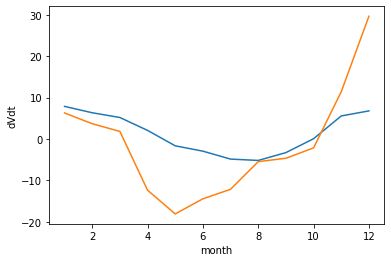

In [81]:
dVdt_clim_bot.plot()
dVdt_clim_deep.plot();

### $\Psi$

In [82]:
psi_clim_deep = clim.psi_vel.sel(sigma2_bin=1037.12, method='nearest') - clim.psi_vel.isel(sigma2_bin=0)
psi_clim_deep.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([ -7.5199566,  -7.328907 ,  -8.180455 ,  -8.84791  ,  -9.558134 ,
       -10.598633 , -10.373601 ,  -8.159185 ,  -8.86673  ,  -7.192584 ,
        -6.578805 ,  -6.9445176], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [83]:
psi_clim_bot = clim.psi_vel.isel(sigma2_bin=-1) - clim.psi_vel.sel(sigma2_bin=1037.12, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([ 7.716251 ,  6.464262 ,  6.8740907,  7.4569945,  8.941543 ,
       10.851117 ,  9.978435 ,  6.9607315,  7.8902583,  5.510927 ,
        5.6254077,  6.4809337], dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

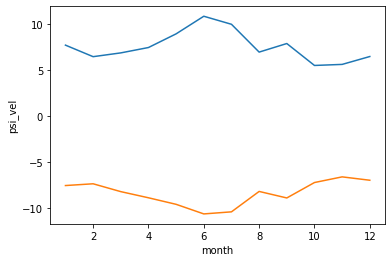

In [84]:
psi_clim_bot.plot()
psi_clim_deep.plot();

### $\Omega$

In [85]:
omega_clim_deep = clim.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest') - clim.omega_trans_rate.isel(sigma2_bin=0)
omega_clim_deep.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([ 12.56796506,  10.06608576,   7.76045379,  -5.08548072,
       -10.7386863 ,  -4.27640837,  -2.24467615,   2.4120371 ,
         3.37446785,   3.45322525,  16.43787511,  37.81538898])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [86]:
omega_clim_bot = clim.omega_trans_rate.isel(sigma2_bin=-1) - clim.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest')
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([  0.63409809,   0.27242706,  -0.58068247,  -4.24941242,
        -9.13491667, -12.78244221, -14.11726833, -10.96433145,
        -9.77585226,  -4.20390009,   0.737893  ,   0.4786975 ])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

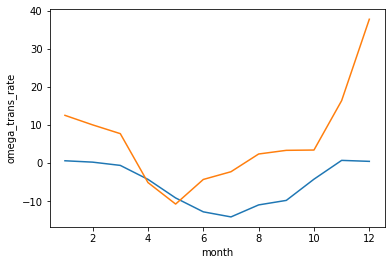

In [87]:
omega_clim_bot.plot()
omega_clim_deep.plot();

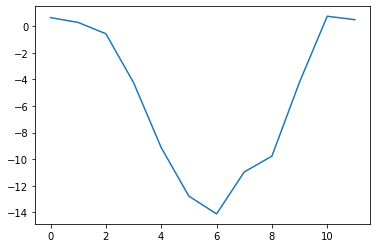

In [91]:
plt.plot(omega_clim_bot)

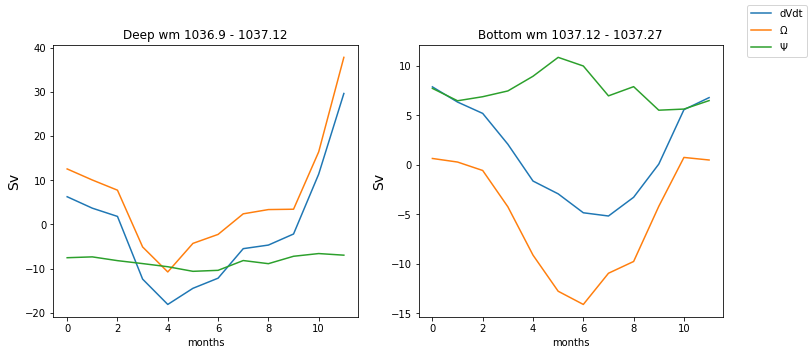

In [107]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_clim_deep, label='dVdt')
ax0.plot(omega_clim_deep, label=r'$\Omega$')
ax0.plot(psi_clim_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_clim_bot)#, label='dVdt')
ax1.plot(omega_clim_bot)#, label=r'$\Omega$')
ax1.plot(psi_clim_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## Anomaly

In [122]:
anom = anom.drop(['time_snp', 'month'])

In [156]:
anom['time'] = pd.to_datetime(anom.time)

In [157]:
anom

<xarray.Dataset>
Dimensions:           (time: 286, sigma2_bin: 99)
Coordinates:
  * sigma2_bin        (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time              (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14
Data variables:
    R1                (time, sigma2_bin) float64 nan nan ... 0.04613 -0.02409
    R2                (time, sigma2_bin) float64 nan nan nan ... -0.1969 -0.1089
    dVdt              (time, sigma2_bin) float32 nan nan ... -0.02977 -0.0358
    omega_mix         (time, sigma2_bin) float64 nan nan nan ... 0.09956 0.1244
    omega_surf_slt    (time, sigma2_bin) float64 nan nan ... 0.02071 0.009463
    omega_surf_th     (time, sigma2_bin) float64 nan nan ... -0.004041 -0.006801
    omega_trans_rate  (time, sigma2_bin) float64 nan nan nan ... 0.1162 0.1271
    psi_vel           (time, sigma2_bin) float32 nan nan nan nan ... 0.0 0.0 0.0

In [109]:
import warnings
warnings.filterwarnings("ignore")

In [129]:
year_start_index = list(np.arange(0, 23, 5) * 12) #[0, 12, 24, 36, 48, ]

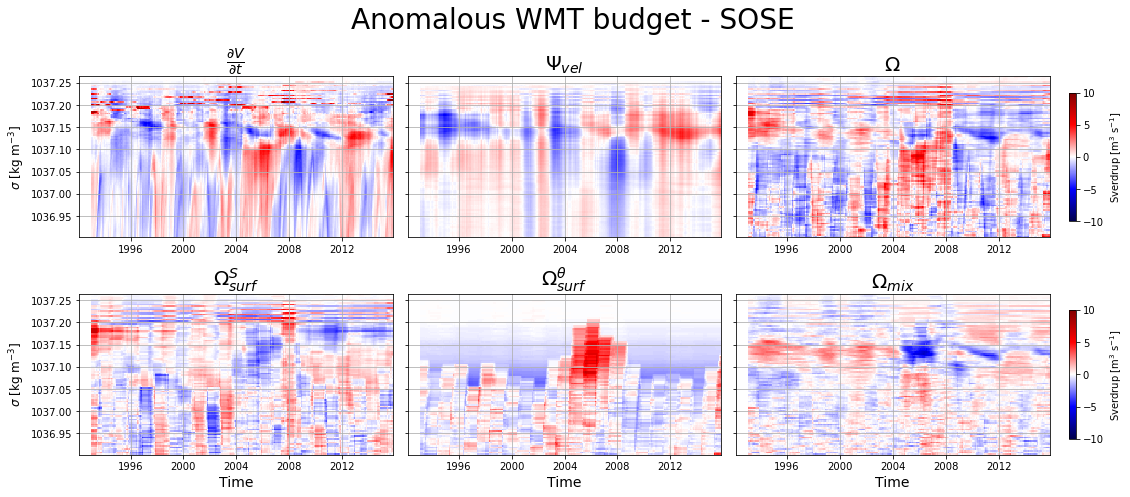

In [161]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()

c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Anomalous WMT budget - SOSE', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [162]:
dVdt_anom_deep = anom.dVdt.sel(sigma2_bin=1037.12, method='nearest') - anom.dVdt.isel(sigma2_bin=0)
dVdt_anom_deep.load()

<xarray.DataArray 'dVdt' (time: 286)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -7.56101847e-01,
       -7.22062588e-01, -6.07308149e-01, -4.10952508e-01,  1.14065611e+00,
        1.77277064e+00,  1.30403066e+00,  1.01174903e+00,  3.47495496e-01,
        2.42796600e-01,  1.07958615e+00, -1.37780920e-01, -1.01500377e-01,
       -1.66486204e-01, -4.28452380e-02,  6.96318865e-01, -2.93877602e-01,
       -1.10595012e+00, -1.83149302e+00, -1.65864301e+00, -1.28194952e+00,
       -1.76301694e+00, -2.50718617e+00, -2.28095126e+00, -2.08748865e+00,
       -1.86652935e+00, -1.80592847e+00, -2.83437848e+00, -2.26244307e+00,
       -9.21405137e-01, -1.01761866e+00, -1.56897497e+00, -1.44849658e+00,
       -7.20581889e-01, -5.38656235e-01,  2.31251419e-01,  1.11719668e-01,
       -2.50814915e-01, -4.43442255e-01,  6.27779543e-01, -3.19288015e-01,
       -1.15145183e+00,  2.11170927e-01,  3.91804874e-01, -8.37206841e-04,
       -1.65721774e-02,  4.56642091e-01, -2.22898602e-01, -3.70893419e-01,
       -6.10911191e-01, -7.24663496e-01, -2.17468452e+00, -1.79978609e+00,
       -1.32004762e+00, -2.42159128e+00, -2.10138083e+00, -1.56972253e+00,
       -2.17723680e+00, -3.04789162e+00, -2.72925138e+00, -2.69099998e+00,
       -2.08685756e+00, -2.32665610e+00, -1.85772252e+00, -3.12060565e-01,
       -9.96873379e-02,  1.17684460e+00,  1.33853650e+00,  1.49091244e+00,
...
       -1.73740387e-02, -8.14161599e-02, -1.13387041e-01, -5.51217198e-01,
       -6.14290476e-01, -8.74061108e-01, -8.70386362e-01, -1.06518519e+00,
       -1.03012168e+00, -8.93852830e-01, -2.29909420e-02, -4.18334484e-01,
        1.29859209e-01, -5.46501875e-02, -2.59036899e-01, -2.03803182e-01,
        3.08907032e-03,  2.01628590e+00,  1.29598832e+00,  7.04409301e-01,
        5.97184420e-01,  3.68009448e-01, -1.29473001e-01, -6.67004585e-02,
       -4.40873921e-01, -8.13934684e-01, -1.17136109e+00, -1.01145971e+00,
       -8.24979186e-01, -2.82668066e+00, -2.29536867e+00, -6.52724624e-01,
        1.17232263e-01,  7.32898057e-01,  4.08780217e-01,  5.93991041e-01,
        1.18623376e+00,  2.21458149e+00,  2.82934499e+00,  3.15139198e+00,
        3.02554631e+00,  3.90880108e+00,  3.67094016e+00,  3.16625404e+00,
        3.13374066e+00,  3.71152210e+00,  4.20817614e+00,  4.73441029e+00,
        4.75301695e+00,  4.12402153e+00,  3.58168554e+00,  2.89016008e+00,
        2.36011791e+00,  2.17974544e+00,  3.23535371e+00,  2.97721457e+00,
        2.36530471e+00,  1.72351456e+00,  6.06414318e-01,  2.94221878e-01,
       -5.37285924e-01, -5.32909453e-01,  1.08279504e-01,  2.14431643e-01,
       -4.28724885e-02, -9.06070411e-01, -1.44042265e+00, -1.09545755e+00,
       -7.45895207e-01, -4.26085830e-01, -1.36598969e+00, -6.82573557e-01,
       -1.86092377e-01,  3.78059030e-01,  5.67044854e-01,  1.58703768e+00,
        9.55737472e-01,  1.30705762e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [163]:
dVdt_anom_bot = anom.dVdt.isel(sigma2_bin=-1) - anom.dVdt.sel(sigma2_bin=1037.12, method='nearest')
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 286)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,  4.34255093e-01,
        1.22942492e-01,  5.12830243e-02,  2.88058698e-01,  1.93922773e-01,
       -3.77748102e-01, -5.25161982e-01, -3.82495850e-01, -2.84541100e-01,
       -5.07587850e-01, -2.41917595e-01,  2.30997175e-01,  2.34812070e-02,
        1.74669936e-01, -5.25474735e-02, -1.36231989e-01,  6.13176823e-02,
        8.75286877e-01,  1.84139001e+00,  1.81399620e+00,  2.05402374e+00,
        2.45817947e+00,  2.73754811e+00,  2.32264733e+00,  2.12940979e+00,
        1.94788861e+00,  2.29677916e+00,  2.27000093e+00,  1.85269511e+00,
        1.47372890e+00,  1.58299875e+00,  1.74263513e+00,  1.47170746e+00,
        1.30295002e+00,  9.03067470e-01,  6.47080839e-01,  6.06580436e-01,
        7.80412912e-01,  5.37334263e-01,  4.00065005e-01,  3.76074880e-01,
        6.35257006e-01, -1.40882850e-01,  1.98575243e-01,  8.43851566e-01,
        7.12812722e-01,  7.34084666e-01,  1.09781706e+00,  1.28699195e+00,
        1.38898861e+00,  1.37060285e+00,  2.08095193e+00,  2.81723976e+00,
        2.58951473e+00,  2.79135990e+00,  2.21790385e+00,  1.43154061e+00,
        1.72686887e+00,  1.40851414e+00,  1.57141030e+00,  1.87312877e+00,
        1.71671534e+00,  1.79418659e+00,  6.62867546e-01, -5.06135464e-01,
       -1.25129879e+00, -1.75022531e+00, -1.78631568e+00, -1.85996222e+00,
...
       -5.84647417e-01, -4.51241791e-01,  2.45532990e-02,  2.22674564e-01,
        5.28466642e-01,  5.35215259e-01,  6.58975720e-01,  9.81754243e-01,
        1.18789995e+00,  1.33558083e+00,  1.41924548e+00,  1.24870133e+00,
        1.35958493e+00,  1.11003983e+00,  8.99550378e-01,  6.88240826e-01,
        7.06077397e-01,  4.96875972e-01,  8.39419901e-01,  9.64531958e-01,
        5.25014162e-01,  4.61316377e-01,  5.98878980e-01,  9.76624608e-01,
        1.37319279e+00,  1.39639068e+00,  1.48230541e+00,  1.26091349e+00,
        8.94134998e-01,  1.39171422e+00,  5.81097543e-01, -4.58028018e-01,
       -9.07975495e-01, -1.42973447e+00, -1.97717381e+00, -2.41017914e+00,
       -3.54431534e+00, -3.54173350e+00, -4.09546375e+00, -4.22794342e+00,
       -4.11611795e+00, -4.25188208e+00, -3.68086457e+00, -3.26137233e+00,
       -3.14519882e+00, -3.70190978e+00, -3.62585664e+00, -3.68883204e+00,
       -3.13169360e+00, -3.11514831e+00, -2.57917285e+00, -2.19037223e+00,
       -1.95835376e+00, -2.32484674e+00, -2.59442186e+00, -2.32000732e+00,
       -1.69272017e+00, -8.50557864e-01, -8.07847619e-01, -1.91892609e-01,
       -2.65563786e-01,  1.21589266e-01, -7.67794997e-02,  3.20578098e-01,
        5.82269788e-01,  8.64240348e-01,  1.14542556e+00,  8.26672554e-01,
        3.70189875e-01,  1.77671574e-02, -2.79259503e-01, -7.10927010e-01,
       -7.73560464e-01, -1.17254221e+00, -1.44847786e+00, -2.87918568e+00,
       -2.20610619e+00, -2.15784287e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

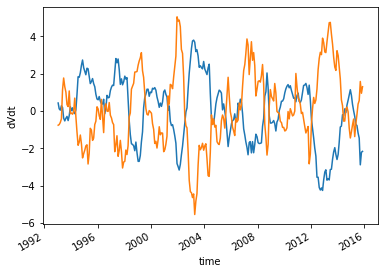

In [164]:
dVdt_anom_bot.plot()
dVdt_anom_deep.plot();

### $\Psi$

In [165]:
psi_anom_deep = anom.psi_vel.sel(sigma2_bin=1037.12, method='nearest') - anom.psi_vel.isel(sigma2_bin=0)
psi_anom_deep.load()

<xarray.DataArray 'psi_vel' (time: 286)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -2.42368460e-01,
       -4.99596596e-02,  1.09764874e-01, -9.41276550e-03,  1.85655057e-01,
        5.58700979e-01,  8.45700145e-01,  1.03440094e+00,  7.12468624e-01,
        6.12767518e-01,  3.88591290e-01,  2.41179213e-01,  2.73721486e-01,
        5.20925410e-02, -6.29556328e-02, -2.87473798e-01, -4.03671890e-01,
       -8.69902611e-01, -1.62424886e+00, -1.70639324e+00, -1.81366408e+00,
       -2.10458684e+00, -2.27276325e+00, -2.28457427e+00, -2.16552114e+00,
       -2.08352423e+00, -2.12428737e+00, -1.90618920e+00, -1.73194432e+00,
       -1.25981224e+00, -1.11508679e+00, -1.26934087e+00, -1.02026093e+00,
       -7.61192083e-01, -6.10297561e-01, -4.35128838e-01, -4.28468496e-01,
       -4.45422679e-01, -3.98003697e-01, -4.68898654e-01, -6.67088926e-01,
       -1.06324673e+00, -7.12828517e-01, -6.81662500e-01, -1.01894677e+00,
       -8.29379499e-01, -8.00003290e-01, -8.74165416e-01, -9.75836515e-01,
       -9.78149831e-01, -8.39021206e-01, -9.00972188e-01, -8.25767457e-01,
       -5.90157390e-01, -6.32593989e-01, -3.73559982e-01,  1.26499534e-02,
       -5.30326903e-01, -2.71918237e-01, -3.82067531e-01, -5.02539277e-01,
       -5.18706322e-01, -6.44062400e-01, -2.97665656e-01,  3.32540423e-02,
        3.14847529e-02,  2.38908753e-01,  1.89255029e-01,  1.69629186e-01,
...
        1.04308403e+00,  8.92727315e-01,  3.73621553e-01,  1.34519041e-01,
        1.33834362e-01, -1.81376189e-03, -1.83574796e-01, -3.90070170e-01,
       -4.12073255e-01, -4.41294253e-01, -2.56307304e-01, -3.40103060e-01,
       -4.51880634e-01, -3.54963481e-01, -3.32633331e-02,  4.75451887e-01,
        4.31871235e-01,  5.22975564e-01,  5.56507826e-01,  6.71386182e-01,
        9.55709934e-01,  1.20863104e+00,  1.44236040e+00,  1.73375094e+00,
        1.62278378e+00,  1.68015373e+00,  1.58023477e+00,  1.11658704e+00,
        1.34355354e+00,  9.62637067e-01,  1.27128863e+00,  1.68455911e+00,
        1.86858678e+00,  1.95787525e+00,  1.79301548e+00,  1.69521463e+00,
        2.28701711e+00,  2.41554785e+00,  2.75823092e+00,  3.01253724e+00,
        2.83322859e+00,  3.14532638e+00,  2.95829940e+00,  2.92711949e+00,
        2.78667641e+00,  2.74278331e+00,  2.75222731e+00,  2.77279329e+00,
        2.36543298e+00,  2.29654264e+00,  1.98944449e+00,  1.83661592e+00,
        1.53476381e+00,  1.56966472e+00,  1.69830394e+00,  1.39659894e+00,
        1.04889750e+00,  7.09154546e-01,  6.63872004e-01,  4.72594321e-01,
        4.41692114e-01,  1.91245794e-01,  2.01632798e-01, -4.69928980e-02,
       -1.24520004e-01, -1.77404463e-01, -5.50118089e-01, -4.84850496e-01,
       -3.53473723e-01, -1.75757155e-01, -2.98816323e-01, -1.54527068e-01,
       -1.42634034e-01,  1.55890197e-01,  3.28998744e-01,  9.31326628e-01,
        8.62083852e-01,  8.36382747e-01], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [166]:
psi_anom_bot = anom.psi_vel.isel(sigma2_bin=-1) - anom.psi_vel.sel(sigma2_bin=1037.12, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 286)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,  9.19785202e-01,
        7.06945181e-01,  6.67408526e-01,  8.67241144e-01,  5.22788465e-01,
       -1.18047878e-01, -4.81366873e-01, -6.89110756e-01, -4.11476314e-01,
       -5.33899426e-01, -2.52958179e-01, -7.16662500e-03, -2.01460302e-01,
       -4.90256250e-02, -7.98922479e-02,  4.95302491e-02,  2.97281802e-01,
        9.78977680e-01,  1.84011483e+00,  1.83903456e+00,  1.91797221e+00,
        2.35764813e+00,  2.59634900e+00,  2.48887300e+00,  2.33044887e+00,
        2.16711831e+00,  2.27648139e+00,  2.03317094e+00,  1.71127939e+00,
        1.05540347e+00,  1.02690649e+00,  1.19050288e+00,  1.02054071e+00,
        6.55066609e-01,  2.94203490e-01, -1.06442496e-02, -6.75874995e-04,
       -1.43022500e-02, -1.95754290e-01, -4.52015437e-02,  1.11406669e-01,
        6.53243959e-01,  2.13789996e-02,  1.00389086e-01,  4.97836322e-01,
        2.85761356e-01,  3.21395189e-01,  6.20427489e-01,  7.21363664e-01,
        8.71255159e-01,  6.66548014e-01,  6.90180302e-01,  6.57670557e-01,
        3.51464123e-01,  5.07687628e-01,  1.58377051e-01, -3.47769260e-01,
        3.49164218e-01,  1.53321087e-01,  3.89725119e-01,  5.74170768e-01,
        4.88950253e-01,  8.32898855e-01,  2.47402370e-01, -1.55047461e-01,
       -2.27476373e-01, -4.28225368e-01, -2.91068196e-01, -2.56122708e-01,
...
       -1.32161748e+00, -1.11534250e+00, -3.60412836e-01, -9.11961719e-02,
       -1.68098465e-01, -3.86128128e-02,  2.79303670e-01,  7.98863769e-01,
        1.00119770e+00,  9.31348205e-01,  7.62711525e-01,  7.41831243e-01,
        7.94729352e-01,  6.19008958e-01,  1.17916502e-01, -4.33915198e-01,
       -4.92152959e-01, -7.84099162e-01, -8.21247876e-01, -1.09236753e+00,
       -1.75991142e+00, -1.92019951e+00, -2.22297859e+00, -2.63539505e+00,
       -2.54182339e+00, -2.44105172e+00, -2.31927395e+00, -1.84895372e+00,
       -2.03091335e+00, -1.43523753e+00, -1.85915995e+00, -2.29233599e+00,
       -2.35828590e+00, -2.42720151e+00, -2.14997816e+00, -1.86409593e+00,
       -2.55636477e+00, -2.71892595e+00, -3.17494345e+00, -3.48556876e+00,
       -3.30767441e+00, -3.51622343e+00, -3.08237386e+00, -2.89046597e+00,
       -2.63950872e+00, -2.74392605e+00, -2.84835768e+00, -2.94297266e+00,
       -2.34638953e+00, -2.30988693e+00, -1.80230689e+00, -1.66571903e+00,
       -1.32934868e+00, -1.52670288e+00, -1.74919140e+00, -1.33961976e+00,
       -9.90625858e-01, -5.81508934e-01, -5.14989614e-01, -2.05520600e-01,
       -1.72656670e-01, -1.90117937e-02, -1.34988129e-01,  2.56854802e-01,
        3.61836195e-01,  4.07600433e-01,  8.03535104e-01,  5.22613108e-01,
        1.97357804e-01, -3.91569175e-02, -7.69712497e-03, -2.12670177e-01,
       -2.67083943e-01, -6.06102049e-01, -8.52566481e-01, -1.61062932e+00,
       -1.47769523e+00, -1.44443643e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

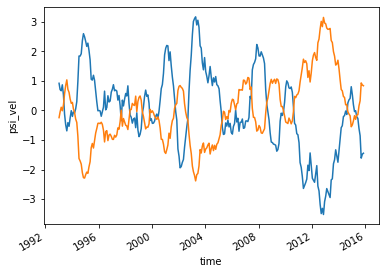

In [167]:
psi_anom_bot.plot()
psi_anom_deep.plot();

### $\Omega$

In [168]:
omega_anom_deep = anom.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest') - anom.omega_trans_rate.isel(sigma2_bin=0)
omega_anom_deep.load()

<xarray.DataArray 'omega_trans_rate' (time: 286)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan, -1.37939299e+00,
       -1.36446285e+00, -1.20831499e+00, -9.49774498e-01,  1.29361366e+00,
        2.23047461e+00,  1.96370886e+00,  1.50219714e+00,  1.51816678e+00,
        1.60928882e+00,  2.70714913e+00,  2.45176563e+00,  2.58913883e+00,
        2.60891622e+00,  2.56202209e+00,  3.26261709e+00,  1.37961101e+00,
        1.42338537e-01,  7.39270758e-02,  5.09189939e-01,  8.52740624e-01,
        6.99282353e-01,  3.90861553e-01, -1.08101122e-01, -3.50017494e-01,
       -2.64277228e-01,  3.48394119e-02, -1.59439915e+00, -8.89805942e-01,
        3.02561407e-01,  7.46072707e-02, -6.93622814e-01, -1.08596465e+00,
       -7.50906749e-01, -1.49144910e+00, -2.49937443e-01, -3.01391338e-01,
       -6.37872816e-01, -5.86331507e-01,  1.29550932e+00,  6.60326294e-01,
       -1.89263164e-02,  4.85079743e-01,  1.03456927e+00,  1.21073010e+00,
        9.17654205e-01,  2.03952432e+00,  7.85716435e-01,  7.26126092e-01,
        4.32362160e-01,  2.05982259e-01, -4.41671561e-01,  6.62376252e-01,
        1.06552949e+00,  3.07256631e-01,  1.18068727e-01,  5.69582445e-02,
        3.28492824e-02, -1.50411030e+00, -5.34269507e-02,  7.77357886e-02,
        1.13020601e+00,  1.16921759e+00,  3.65650187e-01,  9.19851034e-01,
        1.18590296e+00,  1.78419431e+00,  2.10757023e+00,  2.31306015e+00,
...
       -3.66189132e-01, -8.00605819e-01, -7.84454705e-01, -1.01826566e+00,
       -1.13785275e+00, -1.48137030e+00, -1.80366461e+00, -2.31024288e+00,
       -2.45253755e+00, -2.16856005e+00, -3.03958579e-01, -1.27300405e+00,
       -9.48274464e-01, -1.38133587e+00, -1.67396148e+00, -2.09272120e+00,
       -1.88974587e+00,  8.75547071e-01,  1.68244816e-01, -3.16853510e-01,
       -6.96312724e-01, -1.48214393e+00, -2.03073123e+00, -1.94320502e+00,
       -1.93688264e+00, -2.65271044e+00, -2.47274255e+00, -1.85753221e+00,
       -1.52345829e+00, -3.64228574e+00, -2.82757719e+00, -1.90774209e+00,
       -1.03632848e+00, -2.71285377e-01, -1.39995514e+00, -1.47616997e+00,
       -1.49679204e+00,  2.02753986e-01, -1.43645964e-03,  2.81665613e-01,
        5.08149639e-02,  9.60083924e-01,  5.15820675e-01,  3.97715470e-01,
        2.28795175e-01,  5.00391227e-01,  2.79137252e+00,  4.04082859e+00,
        4.42381612e+00,  3.64979274e+00,  3.55431502e+00,  3.01149786e+00,
        2.58212970e+00,  1.91995922e+00,  2.61902203e+00,  2.48779730e+00,
        2.69757704e+00,  2.78752879e+00, -2.71545179e-01, -2.14542389e-01,
       -1.14368897e+00, -8.95686439e-01, -2.82741534e-01, -7.53492681e-02,
       -7.32305570e-02, -7.16175383e-01, -1.08177899e+00, -9.52480086e-01,
       -1.31991932e+00, -1.26345897e+00, -5.86297786e+00, -5.20532424e+00,
       -4.19406925e+00, -3.87461649e+00, -3.77637632e+00, -3.33494218e+00,
       -3.90625729e+00, -3.85443041e+00])
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

In [169]:
omega_anom_bot = anom.omega_trans_rate.isel(sigma2_bin=-1) - anom.omega_trans_rate.sel(sigma2_bin=1037.12, method='nearest')
omega_anom_bot.load()

<xarray.DataArray 'omega_trans_rate' (time: 286)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan, -0.69766018, -0.81443563, -0.83696713, -0.93440637,
       -0.78600332, -0.6068966 , -0.52151062, -0.33408896, -0.64906111,
       -0.8274224 , -0.86082834, -0.92585183, -1.02637202, -1.08532493,
       -0.96836325, -1.00944121, -1.15619967, -1.0508756 , -1.01822592,
       -0.95598013, -0.65496212, -0.70256214, -0.63873783, -0.50382738,
       -0.39784146, -0.18376233, -0.11898054,  0.08359287,  0.17031238,
        0.38429648,  0.59500328,  0.72614694,  0.87187307,  1.21236035,
        1.12568856,  1.093746  ,  1.07307926,  1.00326317,  0.84897624,
        0.50446922,  0.44546945,  0.26873372,  0.36456875,  0.47048228,
        0.51447238,  0.40028708,  0.54439797,  0.62491865,  0.79367054,
        0.93687831,  1.16590864,  1.76487747,  2.16907945,  2.19050865,
        1.96898717,  1.93499503,  1.7043961 ,  1.49006706,  1.3608233 ,
        1.23741907,  0.99338416,  0.71211913,  0.55586039,  0.19423915,
       -0.3137054 , -1.02388802, -1.20027866, -1.46608933, -1.70038675,
       -1.75848435, -1.88306072, -1.87982572, -1.77248424, -1.61457491,
       -1.81501645, -1.88136996, -1.66637198, -0.75079942, -0.57111622,
       -0.51055613, -0.39816553, -0.11400933,  0.27654398,  0.44420876,
        0.54166143,  0.57642071,  0.83393114,  0.94542877,  0.83882697,
...
       -2.74744362, -2.72878382, -2.74223616, -2.86690005, -2.68448931,
       -1.84623735, -1.84469405,  0.19119321,  0.98549451,  1.96681765,
        1.34146815,  0.25752044, -0.05069605, -0.34066889, -0.43794021,
       -0.40797097, -0.51247968, -0.59695198, -0.12846238, -0.19456535,
       -0.1222742 , -0.0473369 ,  0.47777786,  0.47534743,  0.58352061,
        0.78060396,  1.00873423,  1.24459658,  1.50133096,  1.57833006,
        1.77833848,  1.84136343,  1.97930929,  2.02320581,  1.99025669,
        2.26493448,  2.52837577,  2.85921574,  3.06516169,  3.25852205,
        3.5823211 ,  3.97531286,  4.05842721,  4.17637819,  3.99470673,
        3.48192116,  3.27075935,  2.92845345,  2.56465817,  2.04120873,
        1.2759205 ,  0.7459428 , -0.09634522, -0.81450867, -1.43561568,
       -1.63415397, -1.6600745 , -1.40688454, -1.34248785, -1.35142151,
       -1.3583457 , -1.45545019, -1.2004589 , -1.30954115, -1.33694403,
       -1.26595256, -1.03125883, -0.89065623, -0.74516794, -0.60451062,
       -0.65642449, -0.57729422, -0.51854832, -0.52475913, -0.46209729,
       -0.25119824,  0.13193028,  0.43745492,  0.42945017,  0.47569861,
        0.34840935,  0.55037193,  0.72941726,  0.73125205,  0.69625464,
        0.69523158,  0.63378571,  0.59441692,  0.22102513,  0.00954516,
       -0.16762028, -0.16972126, -0.29643629, -1.04557207, -0.46191892,
       -0.38029152])
Coordinates:
  * time     (time) datetime64[ns] 1992-02-13 1992-03-15 ... 2015-11-14

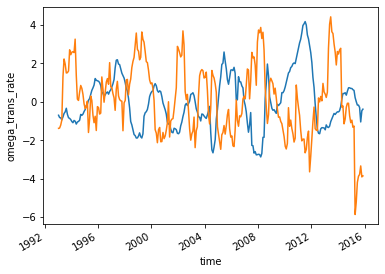

In [170]:
omega_anom_bot.plot()
omega_anom_deep.plot();

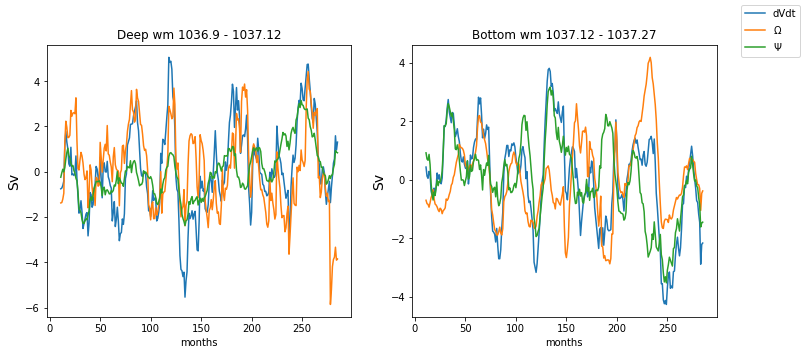

In [171]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_anom_deep, label='dVdt')
ax0.plot(omega_anom_deep, label=r'$\Omega$')
ax0.plot(psi_anom_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_anom_bot)#, label='dVdt')
ax1.plot(omega_anom_bot)#, label=r'$\Omega$')
ax1.plot(psi_anom_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();